# Finalize single-cell RNA-seq data from Hao, 2021 as deconvolution references

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

## Load and process Hao reference data

In [ ]:
# Import parts of the single-cell matrix
counts = sc.read_mtx('../data/references/Hao_2021/GSM5008737_RNA_3P-matrix.mtx').transpose() # cells in rows, gene in columns; anndata object
genes = pd.read_csv('../data/references/Hao_2021/GSM5008737_RNA_3P-features.tsv', sep = '\t', header = None, index_col=0)
barcodes = pd.read_csv('../data/references/Hao_2021/GSM5008737_RNA_3P-barcodes.tsv', sep = '\t', header = None)

In [ ]:
# Import metadata from original study with cell type annotations

annotation = pd.read_csv('../data/references/Hao_2021/GSE164378_sc.meta.data_3P.csv', index_col=0)

In [16]:
# Reconstruct adata from barcodes, features, and counts

adata = counts.copy()
adata.obs_names = barcodes[0].tolist()
adata.var_names = genes[1].tolist()

In [17]:
# Add all three layers of cell type annotation as well as donor and bacth information to data

adata.obs[['cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'individual', 'condition']] = annotation.loc[adata.obs_names.tolist(), ['celltype.l1', 'celltype.l2', 'celltype.l3', 'donor', 'Batch']]

In [18]:
# Inspect cell types annotated at each layer
adata.obs['cell_type_l1'].unique(), adata.obs['cell_type_l2'].unique(), adata.obs['cell_type_l3'].unique()

(array(['Mono', 'CD4 T', 'CD8 T', 'NK', 'B', 'other T', 'other', 'DC'],
       dtype=object),
 array(['CD14 Mono', 'CD4 TCM', 'CD8 Naive', 'NK', 'CD8 TEM', 'CD16 Mono',
        'B intermediate', 'CD4 Naive', 'CD4 CTL', 'B naive', 'MAIT', 'gdT',
        'CD8 TCM', 'dnT', 'B memory', 'Doublet', 'pDC',
        'CD8 Proliferating', 'Treg', 'Plasmablast', 'CD4 TEM', 'cDC2',
        'NK Proliferating', 'ASDC', 'HSPC', 'Platelet', 'NK_CD56bright',
        'CD4 Proliferating', 'Eryth', 'cDC1', 'ILC'], dtype=object),
 array(['CD14 Mono', 'CD4 TCM_1', 'CD8 Naive', 'NK_2', 'CD8 TEM_1',
        'CD16 Mono', 'B intermediate lambda', 'CD4 Naive', 'CD4 CTL',
        'B naive kappa', 'CD4 TCM_3', 'MAIT', 'CD4 TCM_2', 'CD8 TEM_2',
        'gdT_3', 'NK_1', 'CD8 TCM_1', 'dnT_2', 'B intermediate kappa',
        'B memory kappa', 'Doublet', 'pDC', 'CD8 TEM_5', 'gdT_1',
        'B naive lambda', 'NK_4', 'CD8 Proliferating', 'CD8 TCM_2',
        'Treg Naive', 'Plasma', 'CD4 TEM_1', 'Treg Memory', 'CD4 TEM_3'

In [19]:
# Rename cell types in layer 1

rename_dict_l1 = {'Mono' : 'Monocytes',
               'CD8 T' : 'CD8 T cells',
               'CD4 T' : 'CD4 T cells',
               'NK' : 'NK cells',
               'B' : 'B cells',
               'other T' : 'other T cells',
               'DC' : 'DC',
               'other': 'Other'}

adata.obs['cell_type'] = adata.obs['cell_type_l1']
adata.obs.replace({'cell_type' : rename_dict_l1}, inplace=True)
adata.obs

cell_type_l1    cell_type_l2          cell_type_l3  \
L1_AAACCCAAGAAACTCA           Mono       CD14 Mono             CD14 Mono   
L1_AAACCCAAGACATACA          CD4 T         CD4 TCM             CD4 TCM_1   
L1_AAACCCACAACTGGTT          CD8 T       CD8 Naive             CD8 Naive   
L1_AAACCCACACGTACTA             NK              NK                  NK_2   
L1_AAACCCACAGCATACT          CD8 T       CD8 Naive             CD8 Naive   
...                            ...             ...                   ...   
E2L8_TTTGTTGGTCGTGATT        CD8 T       CD8 Naive             CD8 Naive   
E2L8_TTTGTTGGTGTGCCTG         Mono       CD14 Mono             CD14 Mono   
E2L8_TTTGTTGGTTAGTTCG            B  B intermediate  B intermediate kappa   
E2L8_TTTGTTGGTTGGCTAT         Mono       CD16 Mono             CD16 Mono   
E2L8_TTTGTTGTCTCATGGA         Mono       CD14 Mono             CD14 Mono   

                      individual condition    cell_type  
L1_AAACCCAAGAAACTCA           P2    Batch1    Monocytes  
L1_AAACCCAAGACATACA           P1    Batch1  CD4 T cells  
L1_AAACCCACAACTGGTT           P4    Batch1  CD8 T cells  
L1_AAACCCACACGTACTA           P3    Batch1     NK cells  
L1_AAACCCACAGCATACT           P4    Batch1  CD8 T cells  
...                          ...       ...          ...  
E2L8_TTTGTTGGTCGTGATT         P5    Batch2  CD8 T cells  
E2L8_TTTGTTGGTGTGCCTG         P5    Batch2    Monocytes  
E2L8_TTTGTTGGTTAGTTCG         P8    Batch2      B cells  
E2L8_TTTGTTGGTTGGCTAT         P5    Batch2    Monocytes  
E2L8_TTTGTTGTCTCATGGA         P5    Batch2    Monocytes  

[161764 rows x 6 columns]

In [20]:
# Filter low quality cells and genes

sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_genes(adata, min_cells=40)
adata

AnnData object with n_obs × n_vars = 161764 × 19796
    obs: 'cell_type_l1', 'cell_type_l2', 'cell_type_l3', 'individual', 'condition', 'cell_type', 'n_genes'
    var: 'n_cells'

In [21]:
# Change annotation of T regulatory cells

adata.obs.loc[adata.obs["cell_type_l2"] == 'Treg', "cell_type"] = "Tregs"
adata.obs['cell_type'].unique()

array(['Monocytes', 'CD4 T cells', 'CD8 T cells', 'NK cells', 'B cells',
       'other T cells', 'Other', 'DC', 'Tregs'], dtype=object)

## Visualize data via PCA and UMAP

In [22]:
# Function for creation of visualizations

def cluster_data(anndata, anno_layer):
    adata = anndata.copy()
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pl.pca(adata, annotate_var_explained=True, color=anno_layer)
    sc.pp.neighbors(adata)
    sc.tl.umap(adata)
    sc.pl.umap(adata, color=["cell_type", "condition", "individual"])
    plt.tight_layout()

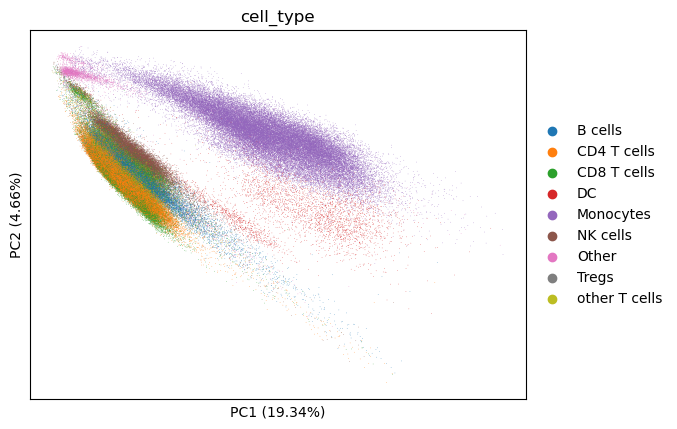

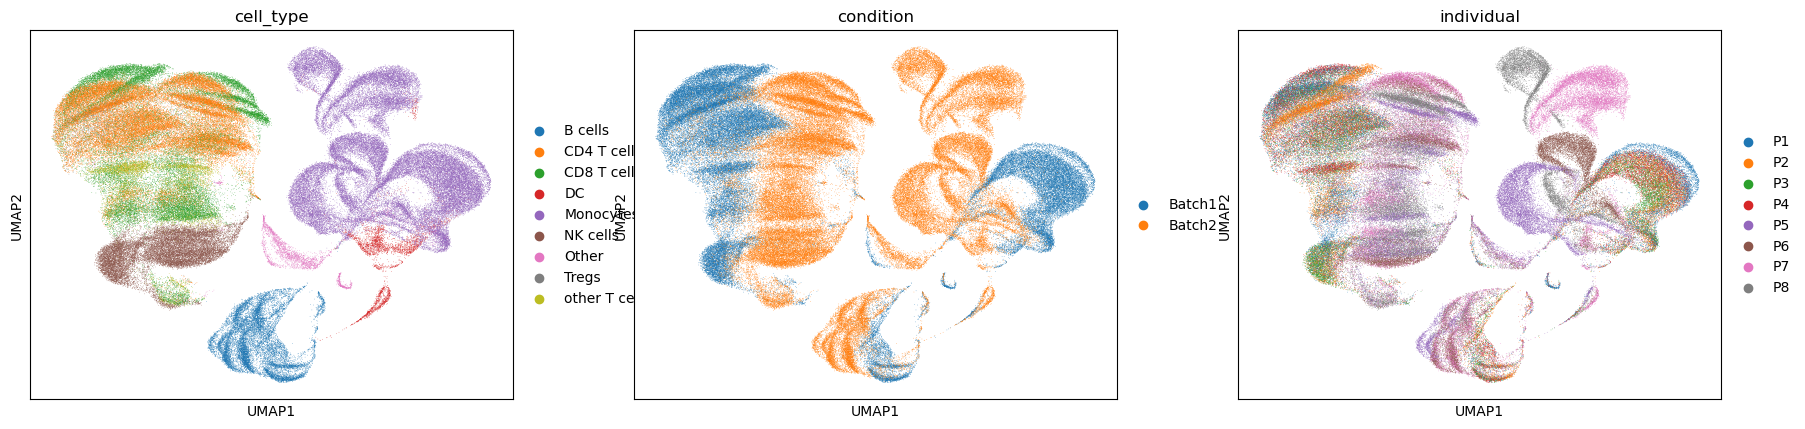

<Figure size 640x480 with 0 Axes>

In [23]:
cluster_data(adata, 'cell_type')

## Prepare data for deconvolution

In [24]:
# Function for data subsetting and splitting

from sklearn.model_selection import train_test_split

def subset_split_adata(adata, cell_types):
    adata_subset = adata.copy()
    adata_subset = adata_subset[adata_subset.obs['cell_type'].isin(cell_types)]
    train_labels, test_labels = train_test_split(adata_subset.obs, test_size=0.2, random_state=42, stratify=adata_subset.obs[['cell_type', 'condition', 'individual']])

    train_adata = adata_subset[train_labels.index.tolist()]
    test_adata = adata_subset[test_labels.index.tolist()]
    
    return train_adata, test_adata

# Save data as h5ad objects

def save_adata(adata_list, name_list):
    import warnings
    warnings.filterwarnings("ignore")
    for i in range(len(adata_list)):
        data_to_save = adata_list[i]
        name = name_list[i]
        data_to_save.write_h5ad(f'{name}.h5ad')
        print(f"Saved {name}.h5ad")

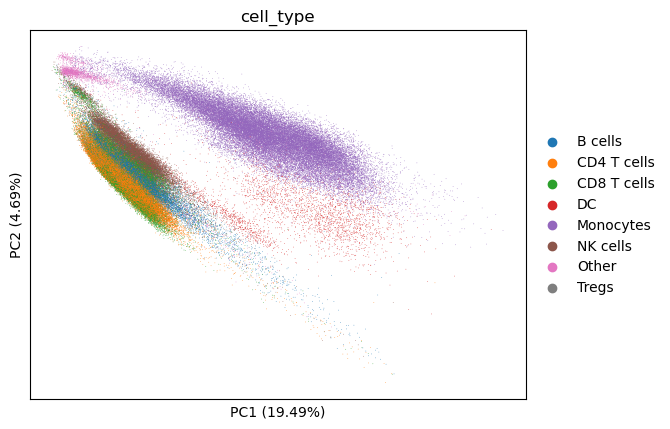

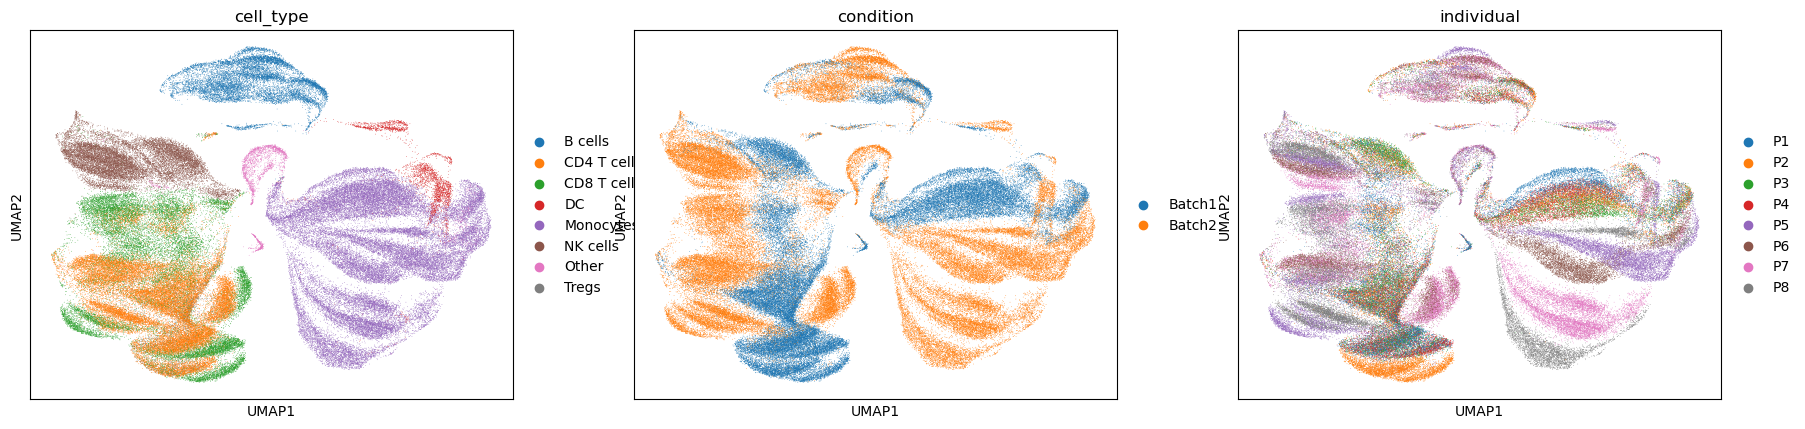

<Figure size 640x480 with 0 Axes>

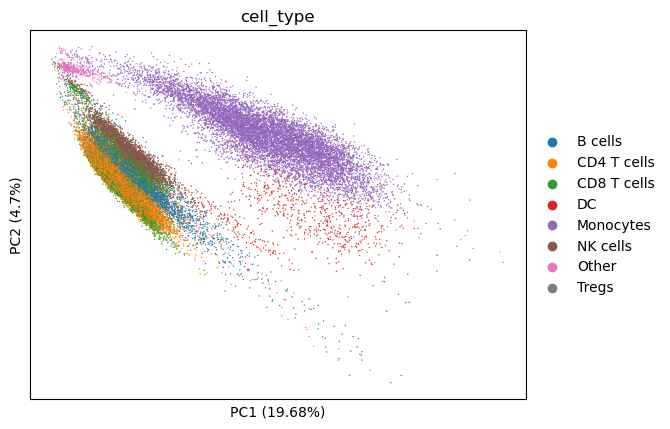

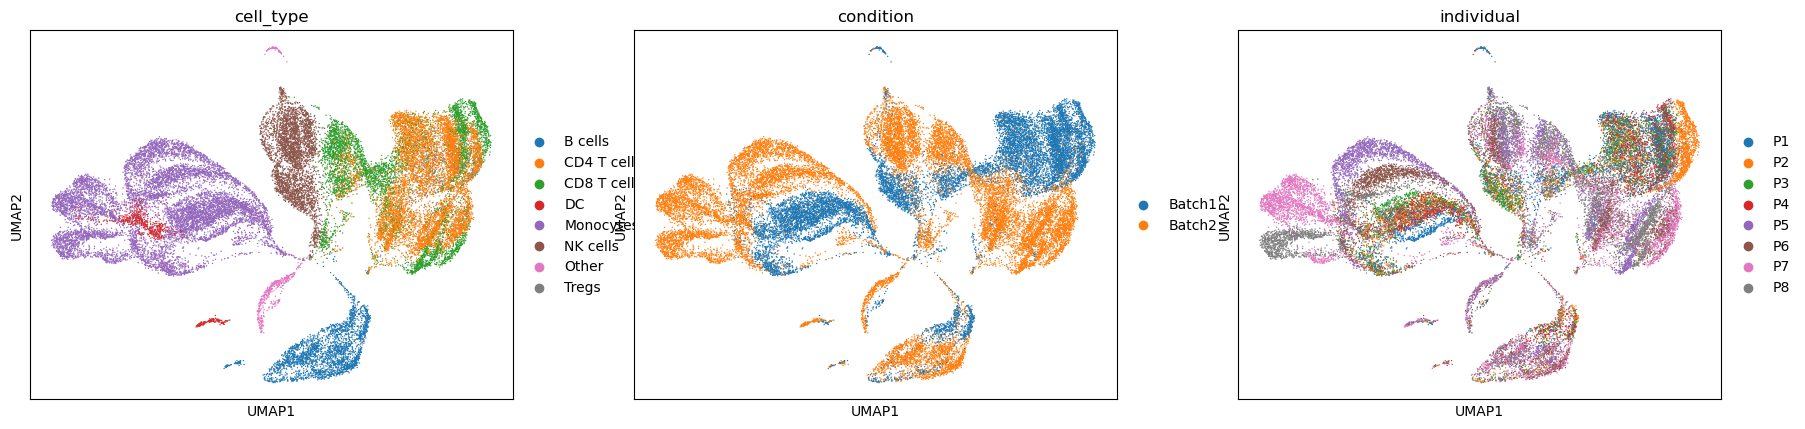

<Figure size 640x480 with 0 Axes>

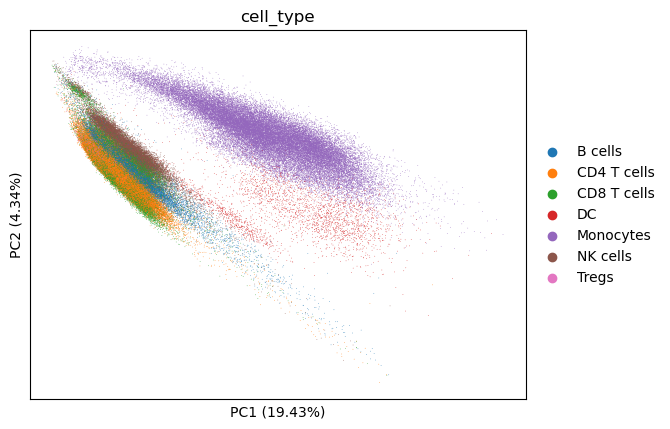

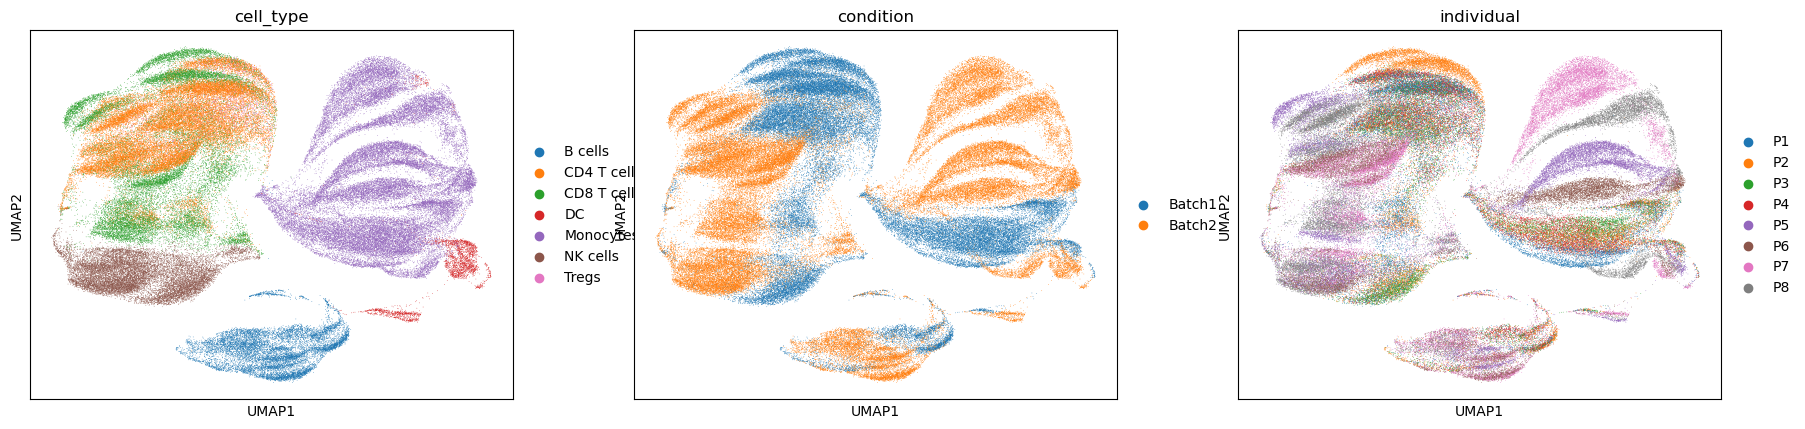

<Figure size 640x480 with 0 Axes>

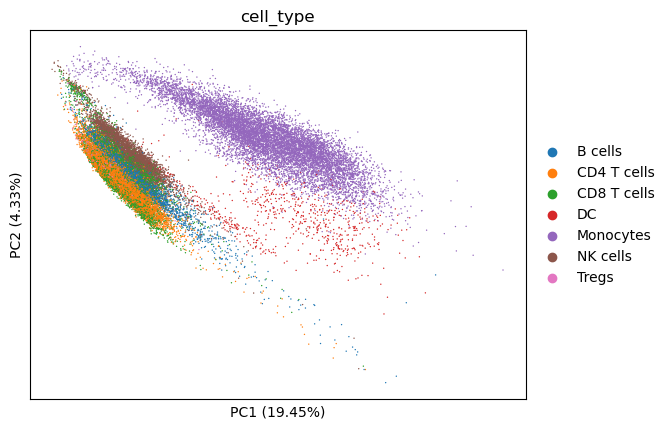

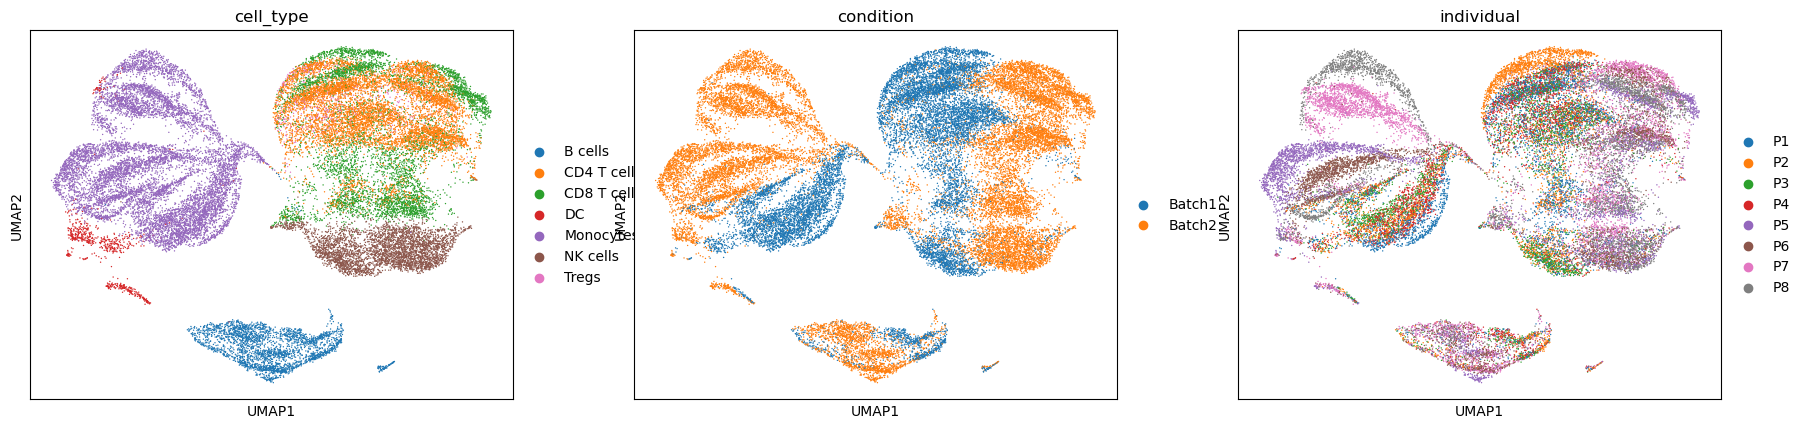

<Figure size 640x480 with 0 Axes>

In [25]:
# Adata for Finotello deconvolution
adata_finotello = adata.copy()

# Target cell types needed for respective deconvolution approaches
cell_types_finotello_1 = ['Monocytes', 'CD4 T cells', 'NK cells', 'DC', 'Tregs', 'Other', 'B cells', 'CD8 T cells']
cell_types_finotello_2 = ['Monocytes', 'CD4 T cells', 'NK cells', 'DC', 'Tregs', 'B cells', 'CD8 T cells']

# Subset and split data for Finotello
set1_hao_train, set1_hao_test = subset_split_adata(adata_finotello, cell_types_finotello_1)
set2_hao_train, set2_hao_test = subset_split_adata(adata_finotello, cell_types_finotello_2)

# Visualize data
cluster_data(set1_hao_train, 'cell_type')
cluster_data(set1_hao_test, 'cell_type')
cluster_data(set2_hao_train, 'cell_type')
cluster_data(set2_hao_test, 'cell_type')

In [26]:
adata_finotello_list = [set1_hao_train, set1_hao_test, set2_hao_train, set2_hao_test]
file_name_list = ['Hao_1_train', 'Hao_1_test', 'Hao_2_train', 'Hao_2_test']
save_adata(adata_finotello_list, file_name_list)

Saved Hao_1_train.h5ad
Saved Hao_1_test.h5ad
Saved Hao_2_train.h5ad
Saved Hao_2_test.h5ad


Hao 2 used in the GrooD paper